## Benchmark 2: minimal OLS

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.plotting_functions as plot_funcs

import pandas as pd
import matplotlib
import statsmodels.api as sm

print(f'Python: {sys.version}')
print()
print(f'Pandas {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}') # type: ignore
print(f'Statsmodels: {sm.__version__}')

# Replace matplotlib with pyplot interface
del matplotlib
import matplotlib.pyplot as plt

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Pandas 1.4.3
Matplotlib: 3.6.3
Statsmodels: 0.13.2


In [2]:
# Read zipped csv into pandas dataframe
training_df = pd.read_csv(f'{conf.DATA_PATH}/train.csv.zip', compression='zip')

# Set dtype on first day of month column
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

# Print out some metadata and sample rows
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [3]:
training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
# Sort each county by timepoint and take the first 3 (most recent) rows from each county
recent_values_df = training_df.sort_values('first_day_of_month', ascending=False).groupby('cfips').head(2)

# Sort by cfips, then timepoint
recent_values_df.sort_values(['cfips', 'first_day_of_month'], inplace=True)

# Number timepoints so we have an easy numeric x variable for regression
if 'timepoint_num' not in list(training_df.columns):
    recent_values_df.insert(1, 'timepoint_num', recent_values_df.groupby(['cfips']).cumcount())

# Clean up
recent_values_df.reset_index(inplace=True, drop=True)

# Take a look
recent_values_df.head()

,row_id,timepoint_num,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-09-01,0,1001,Autauga County,Alabama,2022-09-01,3.442677,1463
1,1001_2022-10-01,1,1001,Autauga County,Alabama,2022-10-01,3.463856,1472
2,1003_2022-09-01,0,1003,Baldwin County,Alabama,2022-09-01,8.341701,14289
3,1003_2022-10-01,1,1003,Baldwin County,Alabama,2022-10-01,8.359798,14320
4,1005_2022-09-01,0,1005,Barbour County,Alabama,2022-09-01,1.206827,239


In [5]:
def OLS_prediction(data, xinput, yinput, xforecast):

    model = sm.OLS(data[yinput], sm.add_constant(data[xinput])).fit()
    predictions = model.predict(sm.add_constant(xforecast))

    return predictions

In [6]:
# Get list of unique cfips
cfips_list = recent_values_df['cfips'].drop_duplicates(keep='first').to_list()

# Loop on cfips list and make OLS predictions for each

predictions = {
    'cfips': [],
    'microbusiness_density': []
}

for cfips in cfips_list:

    prediction = OLS_prediction(
        recent_values_df[recent_values_df['cfips'] == cfips],
        xinput = 'timepoint_num',
        yinput = 'microbusiness_density',
        xforecast = [3, 4, 5, 6, 7, 8, 9, 10]
    )

    predictions['cfips'].extend([cfips] * 8)
    predictions['microbusiness_density'].extend(prediction)

prediction_df = pd.DataFrame(predictions)
prediction_df.head()

,cfips,microbusiness_density
0,1001,3.506212
1,1001,3.527391
2,1001,3.548569
3,1001,3.569748
4,1001,3.590926


In [7]:
prediction_df.tail()

,cfips,microbusiness_density
25075,56045,1.785395
25076,56045,1.785395
25077,56045,1.785395
25078,56045,1.785395
25079,56045,1.785395


In [8]:
# Read zipped csv into pandas dataframe
test_df = pd.read_csv(f'{conf.DATA_PATH}/test.csv')

# Set dtype on first day of month column
test_df['first_day_of_month'] =  pd.to_datetime(test_df['first_day_of_month'])

# Sort by cfips and timepoint to match predictions
test_df.sort_values(['cfips', 'first_day_of_month'], inplace=True)

# Clean up
test_df.reset_index(inplace=True, drop=True)

# Print out some metadata and sample rows
test_df.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


In [9]:
# Concatenate test and prediction dataframes
submission_df = pd.concat([test_df, prediction_df.drop(['cfips'], axis=1)], axis=1)

print(f'Num rows: {len(submission_df)}')
submission_df.head()

Num rows: 25080


,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.506212
1,1001_2022-12-01,1001,2022-12-01,3.527391
2,1001_2023-01-01,1001,2023-01-01,3.548569
3,1001_2023-02-01,1001,2023-02-01,3.569748
4,1001_2023-03-01,1001,2023-03-01,3.590926


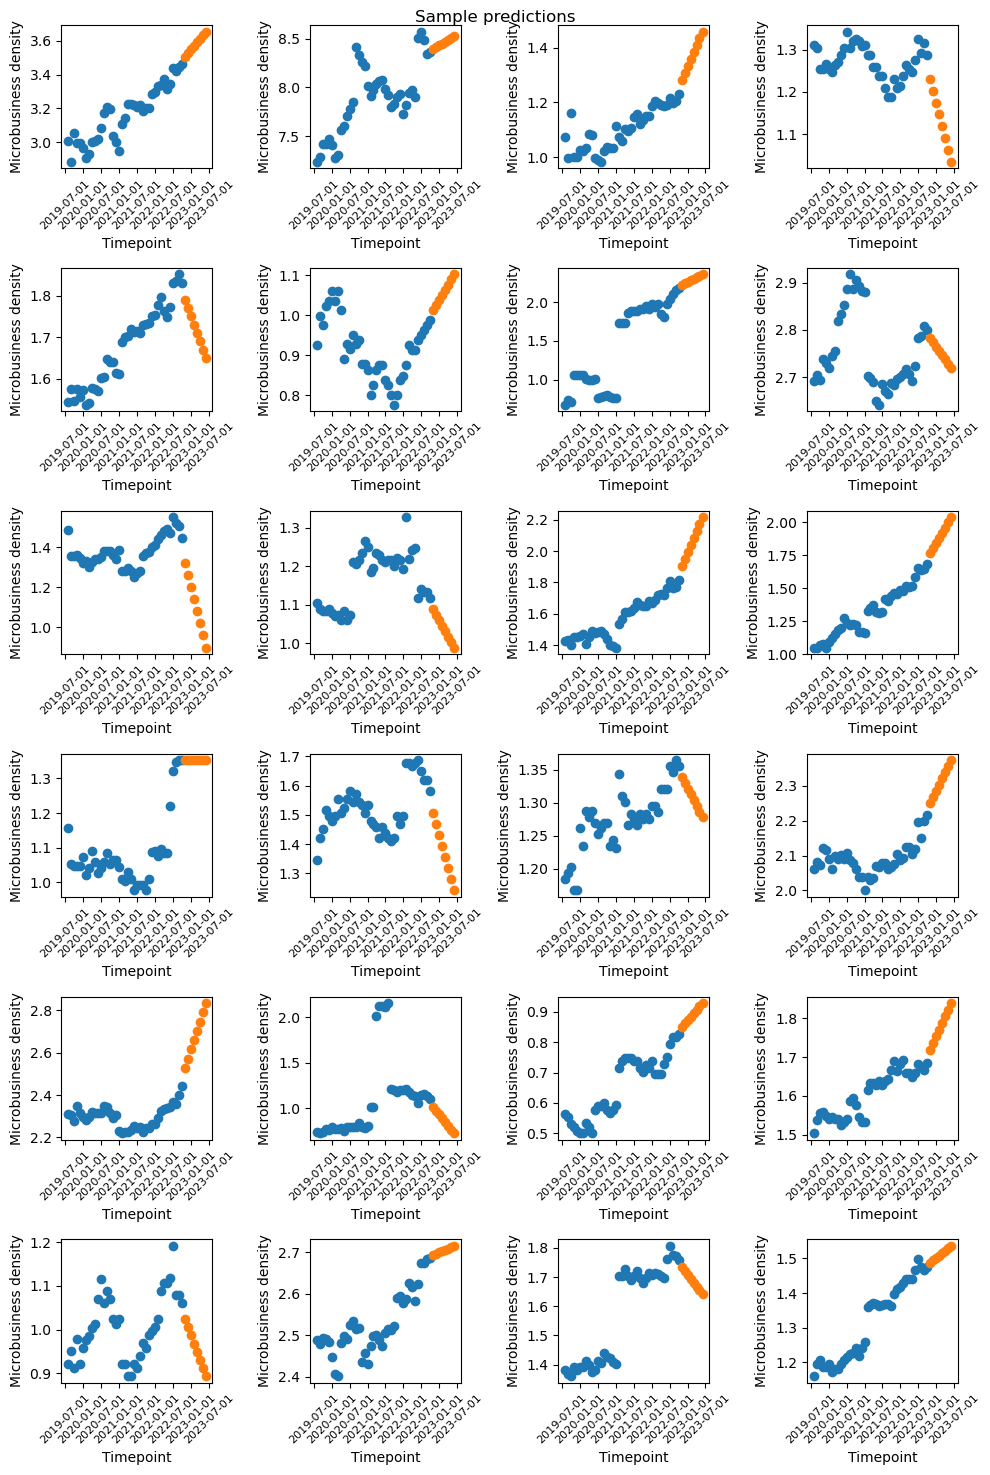

In [10]:
plt = plot_funcs.n_by_n_prediction_scatterplot(
    input_data = training_df,
    predictions = submission_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = cfips_list,
    rows = 6,
    columns = 4,
    fig_height = 15,
    main_title = 'Sample predictions'
)

plt.show()

Better - at least not totally flat this time! Again, not expecting great success here - just want to get a sense of what is possible with simple, common sense methods. Let's submit it and see what happens.

In [11]:
# Drop un-needed rows from our prediction so the format matches the sample submission
submission_df.drop(['cfips', 'first_day_of_month'], axis=1, inplace=True)
print(f'Num rows: {len(submission_df)}')
submission_df.head()

Num rows: 25080


,row_id,microbusiness_density
0,1001_2022-11-01,3.506212
1,1001_2022-12-01,3.527391
2,1001_2023-01-01,3.548569
3,1001_2023-02-01,3.569748
4,1001_2023-03-01,3.590926


In [12]:
# Write csv
output_file = f'{conf.DATA_PATH}/submissions/2023-02-01_minimal_OLS_model_order2_submission.csv'
submission_df.to_csv(output_file, sep=',', index=False)

Gosh, this performs much worse that the totally naive model which just predicts no change! I mean, I didn't think this would be a winning solution, but I would have bet that regressing a few points back from the forecast origin would have helped somewhat. I wonder if part of the issue is that it's not November being scored. This could explain the loss in accuracy. If January is being scored, it would make sense that our OLS fit which only saw data up to October would be way off by the time a few months had passed. I can test this pretty easily by submitting a few dummy predictions with the naive model's values for one month and zeros or NANs for the others. Unfortunately, that experiment will have to wait, I am out of submissions for today. Note to self - be more careful with file uploads in the future!

Anyway, here are the results so far:

* OLS model order 2: SMAPE = 2.487
* OLS model order 3: SMAPE = 1.5563
* OLS model order 6: SMAPE = 2.1876
* Oneshot naive model: SMAPE = 1.0936

Think we need to wait and make sure we know what we are being scored on before we do much else.
